# How to run a shell command using the `AiiDAShell` Node

## Introduction
`AiiDAShell` node is a built-in node, which uses the [aiida-shell](https://aiida-shell.readthedocs.io/en/latest/) package to run shell commands easy. Run any shell executable without writing a dedicated plugin or parser.

This tutorial is based on the [docs](https://aiida-shell.readthedocs.io/en/latest/howto.html#) of the `aiida-shell`

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## Running a shell command
Run a shell command without any arguments. Here we run the `date` command to show the date.

In [2]:
from aiida_workgraph import WorkGraph
from aiida_shell.launch import prepare_code

# Create a code on the local computer
code = prepare_code("date")

# Create a workgraph
wg = WorkGraph(name="test_shell_date")
job1 = wg.nodes.new("AiiDAShell", code=code)
wg.submit(wait=True)

# Print out the result:
print("\nResult: ", job1.node.outputs.stdout.get_content())

WorkGraph node created, PK: 32026

Result:  Mo 06 Mai 2024 08:56:06 CEST



## Running a shell command with arguments
To pass arguments to the shell command, pass them as a list of strings to the arguments keyword:

In [3]:
# Create a workgraph
wg = WorkGraph(name="test_shell_date_with_arguments")
job1 = wg.nodes.new("AiiDAShell", code=code, arguments=['--iso-8601'])
wg.submit(wait=True)

# Print out the result:
print("\nResult: ", job1.node.outputs.stdout.get_content())

WorkGraph node created, PK: 32033

Result:  2024-05-06



## Running a shell command with files as arguments
For commands that take arguments that refer to files, pass those files using the nodes keyword. The keyword takes a dictionary of SinglefileData nodes. To specify where on the command line the files should be passed, use placeholder strings in the arguments keyword.

In [4]:
from aiida.orm import SinglefileData

# Create a code on the local computer
cat_code = prepare_code("cat")
# Create a workgraph
wg = WorkGraph(name="test_shell_cat_with_file_arguments")
job1 = wg.nodes.new("AiiDAShell", code=cat_code,
                    arguments=["{file_a}", "{file_b}"],
                    nodes={
                        'file_a': SinglefileData.from_string('string a'),
                        'file_b': SinglefileData.from_string('string b'),
                    },
                    )
wg.submit(wait=True)

# Print out the result:
print("\nResult: ", job1.node.outputs.stdout.get_content())

WorkGraph node created, PK: 32043

Result:  string astring b


## Create a workflow
We want to calculate `(x+y)*z` in two steps using `echo` and `bc` commands.

Step 1: Calculate (x+y) and store it as result
```
result=$(echo "$x + $y" | bc)
```

Step 2: Multiply result by z and store the final result
```
result=$(echo "$result * $z" | bc)
```
Each step will invole two `ShellNode`s (`echo` and `bc`).

If one wanted to run this workflow in AiiDA, one would have to write plugins for `echo` and `bc` commands, and a WorkChain to handle the workflow. With aiida-workgraph and the `AiiDAShell` node, this can be run through AiiDA with the following workgraph:

In [9]:
from aiida_workgraph import  node, WorkGraph
from aiida_shell.launch import prepare_code
from aiida.orm import Int
from aiida_shell.data import PickledData


echo_code = prepare_code("echo")
bc_code = prepare_code("bc")

def parser(self, dirpath):
    from aiida.orm import Int
    return {'result': Int((dirpath / 'stdout').read_text().strip())}

@node()
def prepare_bc_nodes(file):
    """Prepare the nodes for the bc calculation."""
    return {"expression": file}

@node()
def prepare_echo_nodes(result, z):
    """Prepare the nodes for the echo calculation."""
    return {"result": result,
            "z": z,}

# Create a workgraph
wg = WorkGraph(name="shell_add_mutiply_workflow")
# echo x + y expression
job1 = wg.nodes.new("AiiDAShell", name="job1", code=echo_code, arguments=["{x}", "+", "{y}"],
                    nodes={
                        'x': Int(2),
                        'y': Int(3),
                    },
                )
# bc command to calculate the expression
job2 = wg.nodes.new("AiiDAShell", name="job2", code=bc_code, arguments=["{expression}"],
                    filenames={'expression': 'input.txt'},
                    parser=PickledData(parser),
                )
# add a "result" output socket from the parser
job2.outputs.new("General", "result")
# echo result + y expression
job3 = wg.nodes.new("AiiDAShell", name="job3", code=echo_code, arguments=["{result}", "*", "{z}"],
                )
# bc command to calculate the expression
job4 = wg.nodes.new("AiiDAShell", name="job4", code=bc_code, arguments=["{expression}"],
                    filenames={'expression': 'input.txt'},
                    parser=PickledData(parser),
                )
# prepare the nodes for the bc calculation
nodes1 = wg.nodes.new(prepare_bc_nodes, name="prepare_bc_nodes1")
nodes2 = wg.nodes.new(prepare_echo_nodes, name="prepare_echo_nodes", z=Int(4))
nodes3 = wg.nodes.new(prepare_bc_nodes, name="prepare_bc_nodes2")

wg.links.new(job1.outputs["stdout"], nodes1.inputs["file"])
wg.links.new(nodes1.outputs["result"], job2.inputs["nodes"])
wg.links.new(job2.outputs["result"], nodes2.inputs["result"])
wg.links.new(nodes2.outputs["result"], job3.inputs["nodes"])
wg.links.new(job3.outputs["stdout"], nodes3.inputs["file"])
wg.links.new(nodes3.outputs["result"], job4.inputs["nodes"])
display(wg)
wg.submit(wait=True)

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'shell_a…

WorkGraph node created, PK: 32068


<WorkChainNode: uuid: 84faed74-2c87-4940-80b4-ad853bd622a1 (pk: 32068) (aiida_workgraph.engine.workgraph.WorkGraph)>

In [8]:
print("State of WorkGraph    : {}".format(wg.state))
print('Result               : {}'.format(job4.node.outputs.result.value))

State of WorkGraph    : EXCEPTED


AttributeError: 'AiiDAShell' object has no attribute 'node'

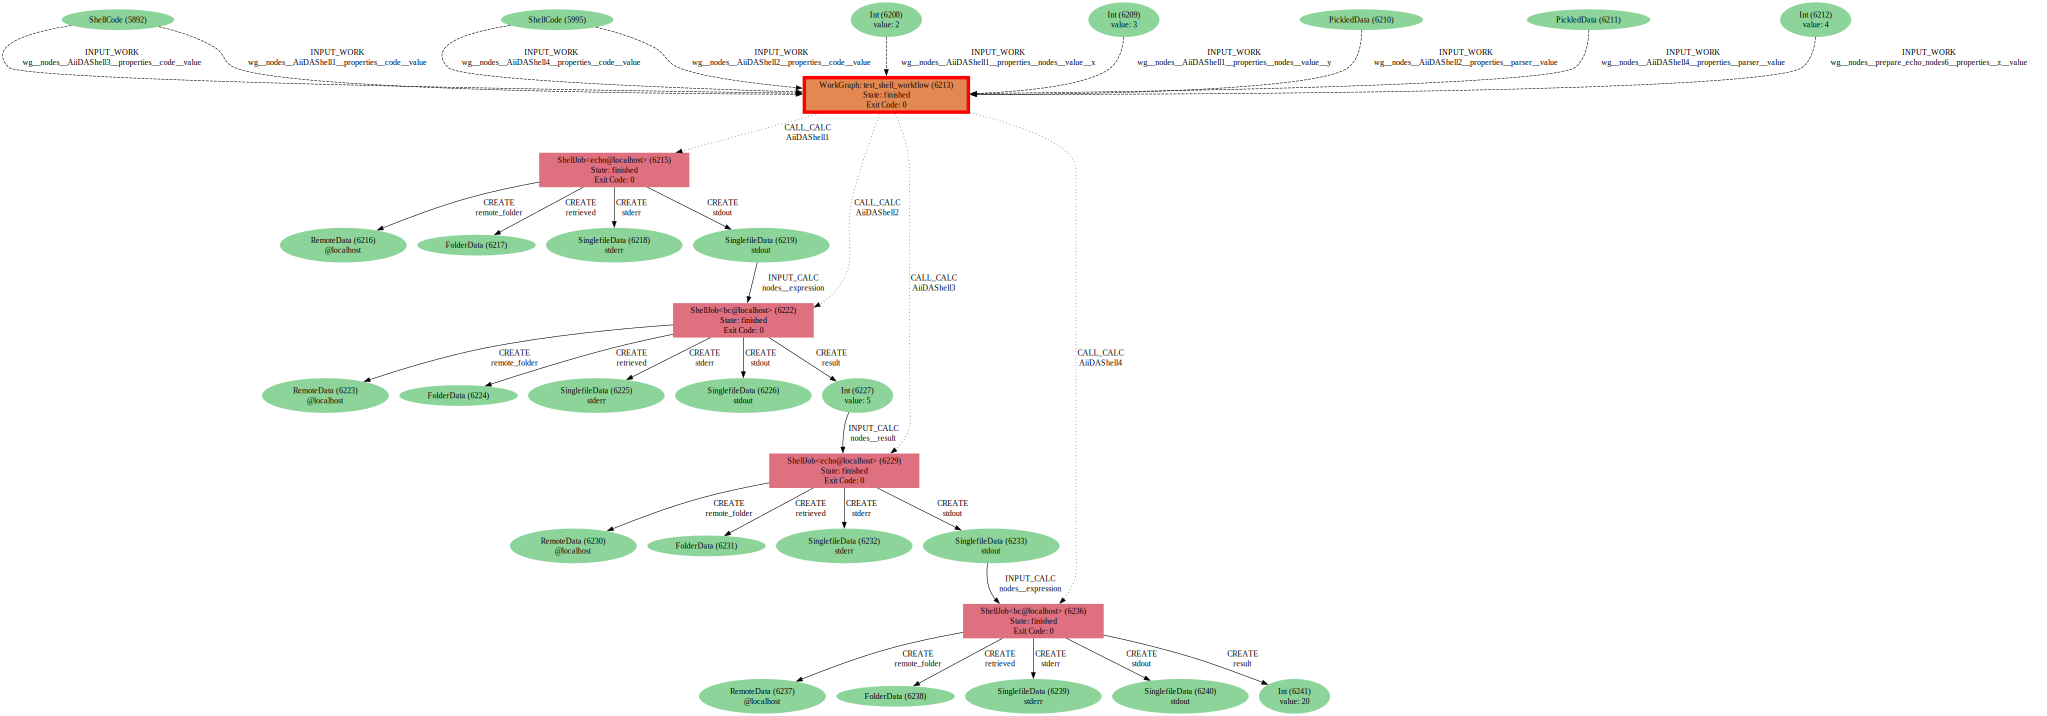

In [37]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## What's Next
For more examples of `aiida-shell`, please refer to its [docs](https://aiida-shell.readthedocs.io/en/latest/howto.html#)